# MCMC CALIBRATION TECHNICS IN CONTEXT OF  INFECTIOUS DISEASE MODELING

## Prerequies

In [ ]:
# pip install multiprocess
# %pip install --upgrade --force-reinstall multiprocess

#Compatible with latest jax version  
# %pip install summerepi2==1.3.6
# %pip install jinja2

In [1]:
import multiprocess as mp
import platform

# This is required for pymc parallel evaluation in notebooks 
# But has to be change while using a python script 
# Use this following instruction instead
# if __name__ == "__main__":
#     if platform.system() != "Windows":
#         mp.set_start_method('spawn')
    
    # rest of your code body here inside the if __name__
if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

In [2]:
import Calibrate as cal #Runing the calibration process and gathering results
from calibs_utilities import get_all_priors, get_targets, load_data
from models.models import model1, model2, bcm_seir_age_strat, bcm_sir #All the models we design for the test
from Calibrate import plot_comparison_bars

# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (bcm_model_1)
from estival.model import BayesianCompartmentalModel
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling.tools import likelihood_extras_for_samples


import pandas as pd
import numpy as np
# import plotly.express as px
import matplotlib.pyplot as plt
from typing import List

import pymc as pm

# We use estivals parallel tools to run the model evaluations
from estival.utils.parallel import map_parallel

import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
import pickle
from datetime import datetime
from plotly import graph_objects as go
# import jax
from jax import numpy as jnp
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting
# pd.options.plotting.backend = "matplotlib"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Application 1: The basic SIR model

## Model Definition and Configuration

A mechanistic model (ODE-Based) model discribing Infectious Disease transmission.

In [ ]:
model_1 = model1() 

In [ ]:
#Defining  a Bayesian Compartmental Model
#Targets and priors are already defined with the data 
#See models.py for the costumization
bcm_model_1 = bcm_sir()
# bcm_model_1 = BayesianCompartmentalModel(model_1, parameters, priors, targets)


### Trial run 

In [ ]:
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting
output_labels = {"index": "time", "value": "number infectious"}

model_1.run(bcm_model_1.parameters)
plt.rcParams["figure.figsize"] = (5, 5)


df = pd.DataFrame(
    {
        "modelled": model_1.get_outputs_df()["I"],
        "observed": bcm_model_1.targets["active_cases"].data,
    }
)
df.plot(kind="scatter", labels=output_labels) #,figsize=(3,3));

### Sampling 

In [ ]:
##____Uniform Initialisation_________
def init_uniform(num_chains, parameters):
    init_vals = []
    for c in range(num_chains):
        init_vals.append({param: np.random.uniform(0.0,1.0) for param in parameters.keys()})
    
    return init_vals


init_vals_nuts = {param: jnp.array(np.random.uniform(0.0,1.0, 4)) for param in bcm_model_1.parameters.keys()}

init_vals_4 = init_uniform(4,bcm_model_1.parameters)
init_vals_6 = init_uniform(6,bcm_model_1.parameters)


In [ ]:
import numpyro
from numpyro import distributions as dist
def nmodel():
    sampled = {k:numpyro.sample(k, dist.Uniform(0.0,1.0)) for k in bcm_model_1.parameters}
    ll = numpyro.factor("ll", bcm_model_1.loglikelihood(**sampled))


#### Simple Run

In [ ]:
%%time
D = 2 # Dimension of the parameter's space
samplers =  [infer.NUTS] + [pm.sample_smc] + [pm.Metropolis] + [pm.DEMetropolisZ] + [pm.DEMetropolis]*2
Draws = [2000] + [2000] + [10000] + [8000]*3
# Tunes = [0] + [100, 1000]*5
Init = [init_vals_nuts] + [init_vals_4]*4 + [init_vals_6]
Chains = [4]*5 + [6]
results_df = pd.DataFrame()

for sampler, draws, chains, init in zip(samplers, Draws, Chains, Init):
    # if sampler.__name__ == "NUTS":
    #     init = init_vals_nuts
    # else:
    #     init = init_vals_4
    results = cal.Single_analysis(sampler = sampler, 
            draws = draws,
            chains=chains,
            cores = chains,
            tune = 1000,
            bcm_model = bcm_model_1,
            # n_iterations = 1,
            nmodel=nmodel,
            # n_jobs = 1,
            initial_params = init

    )
            
    results_df = pd.concat([results_df,results])



results_df = results_df.reset_index(drop=True)


In [ ]:
results_df
results_df.style.set_caption("MCMC COMPARISON") 


In [ ]:

#Storing results on a pickle file
with open('./Results/Model_1/Simple_run_results_3.pkl', 'wb') as fp:
    pickle.dump(results_df, fp)

In [ ]:
#Loading a pickle file
with open('./Results/Model_1/Simple_run_results_3.pkl', 'rb') as fp:
    res = pickle.load(fp)

# res = pd.concat(res)

In [ ]:
res

In [ ]:
Trace = res.Trace

In [ ]:
idata = Trace[3]

In [ ]:
idata

##### Bar Ploting Comparison

In [ ]:
# plot_comparison_Bars(results_df=res)
plot_comparison_bars(res.round(2))

#### Multiple runs

In [ ]:
all_results = dict()

In [ ]:
sampler = pm.sample_smc
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 2000,
    tune = 1000,
    chains=4,
    cores=4, 
    bcm_model = bcm_model_1,
    nmodel=nmodel,
    n_iterations = 100,
    n_jobs = 3,
    initial_params = init_vals_4
    )

In [ ]:
sampler = pm.DEMetropolis
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 8000,
    tune = 1000,
    chains=6,
    cores=4, 
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 3,
    initial_params = init_vals_6
    )

In [ ]:
sampler = pm.DEMetropolisZ
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 8000,
    chains=4,
    cores=4,
    tune = 1000, 
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 3,
    initial_params = init_vals_4
    )

In [ ]:
sampler = pm.Metropolis
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 10000,
    tune = 1000, 
    chains=4,
    cores=4,
    bcm_model = bcm_model_1,
    n_iterations = 100,
    n_jobs = 3,
    initial_params = init_vals_4
    )

In [ ]:
sampler = infer.NUTS
all_results[sampler.__name__] = cal.multirun(
    sampler, 
    draws = 2000,
    tune = 1000,
    chains=4,
    cores=4, 
    bcm_model = bcm_model_1,
    nmodel=nmodel,
    n_iterations = 100,
    n_jobs = 2,
    initial_params = init_vals_nuts
    )

In [ ]:
#Storing the results for later analysis

with open('./Results/Model_1/Multi_run_results_3.pkl', 'wb') as fp:
    pickle.dump(all_results, fp)


#### Summarizing the 100 results

We call the function group_summary from the calibrate modules. This will help to figure out the average performance
of sampler over 100 runs

In [ ]:
#Loading a pickle file
with open('./Results/Model_1/Multi_run_results_3.pkl', 'rb') as fp:
    multi_res = pickle.load(fp)

In [ ]:
df = pd.concat(multi_res)

In [ ]:
summaries_mean, prcnt_succ = cal.group_summary(df)

In [ ]:
prcnt_succ

## Using arviz for trace visualization

In [ ]:
for idata, Run, draws, tune in zip(res.Trace, res.Run, res.Draws, res.Tune):
    subset = idata.sel(draw=slice(0, None), groups="posterior")
    print("Run = ",Run)
    az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False)#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
    plt.show()



### Fitting test

Here we test if the model is well fitted to the data, we will use the results from the single run

In [ ]:
IDATA = res["Trace"]

In [ ]:
map_res = dict()
for idata, run in zip(IDATA,res["Run"]):
    # print(idata)
    map_res[run] = cal.fitting_test(idata, bcm_model_1, model_1)

In [ ]:
modelled = map_res["NUTS\nDraws=2000\nTune=1000"]["I"]


df = pd.DataFrame(
    {
        "modelled": modelled,
        "observed": bcm_model_1.targets["active_cases"].data,
    }
)
df.plot(kind="scatter", labels=output_labels, title="Model fitting")

## Uncertainty sampling

In [ ]:
# Use the arviz extract method to obtain some samples, then convert to a DataFrame
sample_idata = az.extract(idata, num_samples=4000)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])


In [ ]:
# Wrapper function captures our bcm from the main namespace to pass into map_parallel
# Using this idiom in closures/factory functions is typical
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm_model_1.run(params)

# Run the samples through our BCM using the above function
# map_parallel takes a function and an iterable as input

# We use 4 workers here, default is cpu_count/2 (assumes hyperthreading)
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)


In [ ]:
# We'll use xarray for this step; aside from computing things very quickly, it's useful
# to persist the run results to netcdf/zarr etc

import xarray as xr

In [ ]:
map_res = cal.fitting_test(idata, bcm_model_1, model_1)

In [ ]:
map_res["I"]

In [ ]:
# Build a DataArray out of our results, then assign coords for indexing
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]), 
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"], 
                          time=map_res.index, variable=pd.DataFrame(map_res["I"]).columns)

In [ ]:
# Set some quantiles to calculate
quantiles = (0.5,0.75,0.95)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [ ]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

In [ ]:
variable = "active_cases"
pd.options.plotting.backend = "matplotlib" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

fig = uncertainty_df["I"].plot.area(title=variable,alpha=0.7)
pd.Series(map_res["I"]).plot(label = "modelled",style='--')
bcm_model_1.targets[variable].data.plot(label = "observed",style='.',color="black", ms=5, alpha=0.8)
plt.legend()

## Analysing the posterior likelihood landscape analysis using ELA

In [ ]:
# !pip install pflacco
from pflacco.classical_ela_features import *
from pflacco.local_optima_network_features import compute_local_optima_network, calculate_lon_features
#__To___create_a_initial____sample
from pflacco.sampling import create_initial_sample

# Application 2: The SEIR age-stratified model

## Data for fitting
Here we will define a target for each age category

In [3]:
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

df = pd.DataFrame()
df = pd.read_csv("./data/new_cases_England_2020.csv")
df["date"] = pd.to_datetime(df.date)
df.set_index(["age","date"], inplace=True)



In [4]:
total_cases = df.groupby("date").sum()
#Rolling by 14 days to discard fluctuations
total_cases = total_cases.rolling(14).mean().iloc[14:]

## Model Definition


In [5]:
model_config = {"compartments": ("S", "E","I","R"), # "Ip","Ic", "Is", "R"),
        "population": 56490045, #England population size 2021
        "seed": 70.0,
        "start": datetime(2020, 8, 1),
        "end_time": datetime(2020, 11, 30)
}
bcm_model_2 = bcm_seir_age_strat(model_config)
model_2 = model2(model_config)

In [6]:
T = bcm_model_2.targets

## Trial run

In [7]:
res = bcm_model_2.run(bcm_model_2.parameters,include_extras=False).derived_outputs

# res = model_2.get_outputs_df()
Infec = [f"IXage_{i}" for i in range(0,65,5)]
total_cases_pred = pd.DataFrame(res[Infec].sum(axis=1))

In [8]:
total_cases_pred = total_cases_pred.rolling(14).mean()[14:]

In [9]:

plot_start_date = datetime(2020, 8, 1)
analysis_end_date = datetime(2020, 11, 30)

# plot = model_2.get_outputs_df()["IXage_60"].plot()
plot = pd.DataFrame(total_cases_pred).plot()
plot.update_xaxes(range=(plot_start_date, analysis_end_date))
plot.add_trace(go.Scatter(x=total_cases.index, y=total_cases["cases"], mode='markers', name='total_cases'))
#pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting
#pivot_df["total_cases"].plot.area()

## Calibration

In [10]:
##____Uniform Initialisation for each chain_________
chains = 4
init_vals = []
for c in range(chains):
    temp = {param: np.random.uniform(0.0,1.0) for param in list(bcm_model_2.parameters.keys())[:-2]}
    temp["incubation_period"] = np.random.uniform(1.,15.) 
    temp["infectious_period"] = np.random.uniform(1.,15.)
    init_vals.append(temp)


init_vals_nuts = {param: jnp.array(np.random.uniform(0.0,1.0, 4)) for param in list(bcm_model_2.parameters)[:-2]}
init_vals_nuts["incubation_period"] = jnp.array(np.random.uniform(1.,15.0, 4))
init_vals_nuts["infectious_period"] = jnp.array(np.random.uniform(1.,15.0, 4))

In [11]:
def nmodel_2():
    unif_priors = list(bcm_model_2.parameters)[:-2]
    sampled = {k:numpyro.sample(k, dist.Uniform(0.0,1.0)) for k in unif_priors}
    #Adding the normal priors for the incubation and infectious periods
    sampled["incubation_period"] = numpyro.sample("incubation_period", dist.TruncatedNormal(7.3, 2.0, low=1., high=14.))
    sampled["infectious_period"] = numpyro.sample("infectious_period", dist.TruncatedNormal(5.4, 3.0, low=1., high=14.))
    # Log-likelihood
    log_likelihood = bcm_model_2.loglikelihood(**sampled)

    numpyro.factor("ll",log_likelihood)

In [12]:
res = cal.Single_analysis(sampler = pm.DEMetropolisZ, 
            draws = 10000,
            tune = 2000,
            chains = 4,
            cores=4,
            bcm_model = bcm_model_2,
            # n_iterations = 1,
            # n_jobs = 1,
            nmodel=nmodel_2,
)
            # initial_params = init_vals)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [incubation_period, infectious_period, age_transmission_rate_0, age_transmission_rate_5, age_transmission_rate_10, age_transmission_rate_15, age_transmission_rate_20, age_transmission_rate_25, age_transmission_rate_30, age_transmission_rate_35, age_transmission_rate_40, age_transmission_rate_45, age_transmission_rate_50, age_transmission_rate_55, age_transmission_rate_60, IXage_0_disp, IXage_5_disp, IXage_10_disp, IXage_15_disp, IXage_20_disp, IXage_25_disp, IXage_30_disp, IXage_35_disp, IXage_40_disp, IXage_45_disp, IXage_50_disp, IXage_55_disp, IXage_60_disp]
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 129 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable 

In [ ]:
res_smc = cal.Single_analysis(sampler = pm.sample_smc, 
            draws = 30000,
            tune = 0,
            chains = 4,
            cores=4,
            bcm_model = bcm_model_2,
            nmodel=nmodel_2,
            initial_params = init_vals)

In [ ]:
from jax import random
from numpyro.infer import init_to_feasible, init_to_mean, init_to_sample, init_to_median,init_to_value, init_to_uniform


In [ ]:
kernel = infer.NUTS(nmodel_2, target_accept_prob=0.75, dense_mass=True, init_strategy=init_to_sample())
mcmc = infer.MCMC(kernel, num_warmup=10, num_chains=chains, num_samples=100, progress_bar=True)

mcmc.run(random.PRNGKey(1))
idata1 = az.from_numpyro(mcmc)

In [ ]:
kernel = infer.NUTS(nmodel_2, target_accept_prob=0.75, dense_mass=True, init_strategy=init_to_mean())
mcmc = infer.MCMC(kernel, num_warmup=10, num_chains=chains, num_samples=100, progress_bar=True)

mcmc.run(random.PRNGKey(1))

idata2 = az.from_numpyro(mcmc)

In [ ]:
kernel = infer.NUTS(nmodel_2, target_accept_prob=0.75, dense_mass=True, init_strategy=init_to_median())
mcmc = infer.MCMC(kernel, num_warmup=10, num_chains=chains, num_samples=100, progress_bar=True)

mcmc.run(random.PRNGKey(1))
idata3 = az.from_numpyro(mcmc)

In [ ]:
kernel = infer.NUTS(nmodel_2, target_accept_prob=0.75, dense_mass=True, init_strategy=init_to_uniform())
mcmc = infer.MCMC(kernel, num_warmup=10, num_chains=chains, num_samples=100, progress_bar=True)

mcmc.run(random.PRNGKey(1))
idata4 = az.from_numpyro(mcmc)

In [ ]:
res_nuts = cal.Single_analysis(sampler = infer.NUTS, 
            draws = 1000,
            tune = 10,
            chains = 4,
            cores=4,
            bcm_model = bcm_model_2,
            nmodel=nmodel_2,
            initial_params = init_vals_nuts)

In [13]:
idata = res["Trace"]
idata = idata[0]
burn_in = 50000
# subset = idata.sel(draw=slice(burn_in, None), groups="posterior")


In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
incubation_period,8.400,2.055,4.459,12.158,0.286,0.203,53.0,712.0,1.08
infectious_period,3.800,0.778,2.352,5.237,0.050,0.036,237.0,384.0,1.03
age_transmission_rate_0,0.433,0.215,0.090,0.856,0.062,0.045,14.0,74.0,1.22
age_transmission_rate_5,0.414,0.172,0.088,0.743,0.012,0.009,198.0,144.0,1.08
age_transmission_rate_10,0.503,0.189,0.125,0.825,0.020,0.014,118.0,501.0,1.06
age_transmission_rate_15,0.394,0.214,0.015,0.738,0.059,0.042,12.0,17.0,1.24
age_transmission_rate_20,0.463,0.204,0.101,0.831,0.026,0.018,74.0,488.0,1.06
age_transmission_rate_25,0.529,0.219,0.133,0.912,0.045,0.035,25.0,141.0,1.12
age_transmission_rate_30,0.486,0.202,0.129,0.868,0.022,0.017,90.0,462.0,1.05
age_transmission_rate_35,0.435,0.210,0.055,0.809,0.028,0.020,55.0,121.0,1.07


c:\Users\abdou\anaconda3\envs\emulearn\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (28), generating only 20 plots



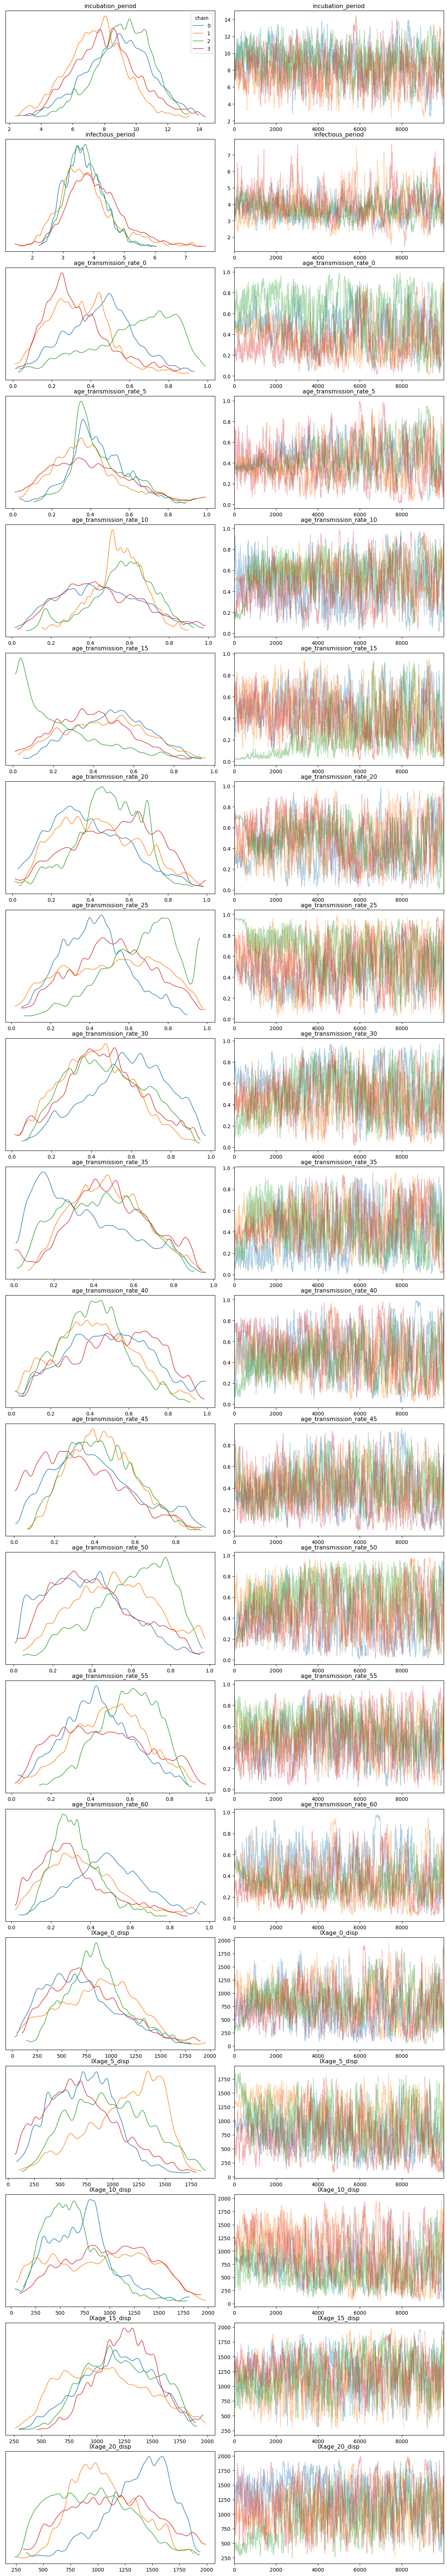

In [15]:
az.plot_trace(idata, figsize=(12,2.5*len(idata.posterior)),compact=False, legend=True)
plt.tight_layout(pad = 0.005)


In [ ]:
az.plot_posterior(idata)

In [16]:
def fitting_test(sampler,idata, bcm, model):
    from estival.sampling.tools import likelihood_extras_for_samples,likelihood_extras_for_idata
    if sampler.__name__ in ["DEMetropolis", "DEMetropolisZ"]:
        likelihood_df = likelihood_extras_for_idata(idata, bcm)
    else :
        likelihood_df = likelihood_extras_for_samples(idata.posterior, bcm)

    ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

    # Extract the parameters from the calibration samples
    map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
    bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]
    # Run the model with these parameters
    model.run(map_params)
    # ...and plot some results
    return model.get_outputs_df()

In [17]:
map_res = fitting_test(pm.DEMetropolisZ,idata, bcm_model_2,model_2)

In [18]:
Infec = [f"IXage_{i}" for i in range(0,65,5)]


In [19]:
total_cases_pred = map_res[Infec].sum(axis=1)

In [20]:
total_cases_pred = total_cases_pred.rolling(14).mean()[14:]

In [22]:
plot_start_date = datetime(2020, 8, 1)
analysis_end_date = datetime(2020, 11, 30)

plot= map_res["IXage_5"].plot()
# plot = total_cases_pred.plot()
plot.update_xaxes(range=(plot_start_date, analysis_end_date))
plot.add_trace(go.Scatter(x=df.loc["05_09"].index, y=df.loc["05_09"]["cases"], mode='markers', name='observed'))
# plot.add_trace(go.Scatter(x=total_cases.index, y=total_cases["cases"], mode='markers', name='total_cases'))